In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import json
from torchvision import transforms
from tqdm import tqdm
from torchvision import datasets, transforms
from IPython.display import display, clear_output
%matplotlib inline

In [12]:
class Visualizer():
    def __init__(self, num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='', tight=False, cm=None):
        self.fig, self.axs = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
        # remove ticks
        if axis_off:
          plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        # set colormap
        if cm is not None:
            plt.set_cmap(cm)
        # set supertitle
        self.fig.suptitle(title)
        if tight:
            self.fig.subplots_adjust(top=0.88)

    def add_image_subplot(self, i, j, image, normalize=False, title_str=''):
        if normalize:
            image = self.normalize_image(image)
        if len(image.shape) == 3:
            #BGR -> RGB
            image = image[:, :, ::-1]
        self.axs[i, j].imshow(image)
        self.axs[i, j].set_title(title_str)

    def show(self):
        display(self.fig)
        clear_output(wait = True)
        plt.pause(0.05)

    def add_stem_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].stem(x, y)
        self.axs[i, j].set_title(title_str)

    def add_subplot(self, i, j, data, title_str=''):
        self.axs[i, j].plot(data)
        self.axs[i, j].set_title(title_str)

    def add_subplot_xy(self, i, j, x, y, title_str=''):
        self.axs[i, j].plot(x,y)
        self.axs[i, j].set_title(title_str)

    def add_bar_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].bar(x, y)
        self.axs[i, j].set_title(title_str)

    @staticmethod
    def normalize_image(image):
        img = np.float64(image) - np.min(image)
        img /= np.max(img)
        return img

In [13]:
class Model(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(128, 32, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
        ])
        self.final_conv1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.final_conv2 = nn.Conv2d(16, out_channels, kernel_size=3, padding=1)
        self.act = nn.LeakyReLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, timestep):
        skips = []
        for i, layer in enumerate(self.down_layers):
            x = self.act(layer(x))
            if i < 2:
              skips.append(x)
              x = self.downscale(x)

        for i, layer in enumerate(self.up_layers):
            if i > 0:
              x = self.upscale(x)
              x = torch.concatenate( [x, skips.pop()], axis=1)
            x = self.act(layer(x))

        x = self.act(self.final_conv1(x))
        x = self.final_conv2(x)
        return x

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# TODO: filter training imgs

filter = [i for i in range(len(cifar_train)) if cifar_train.targets[i] == 1]
cifar_train_reduced = torch.utils.data.Subset(cifar_train, filter)

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(cifar_train_reduced, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


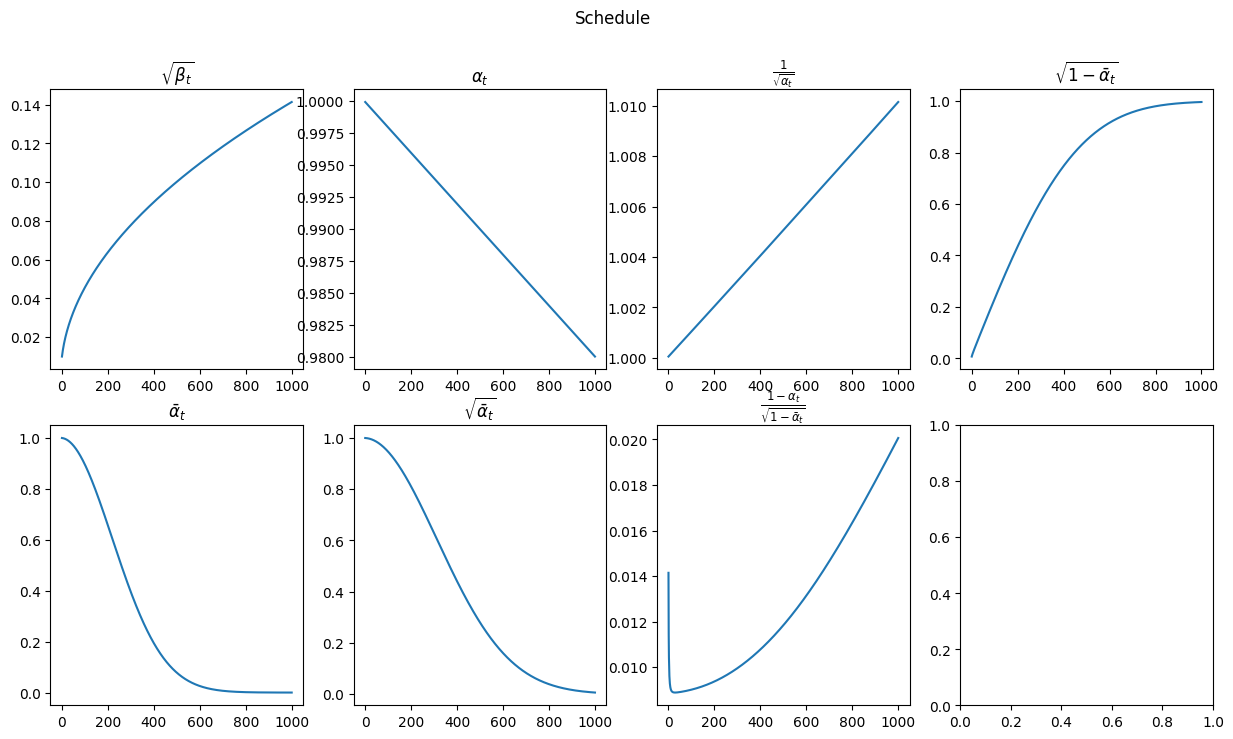

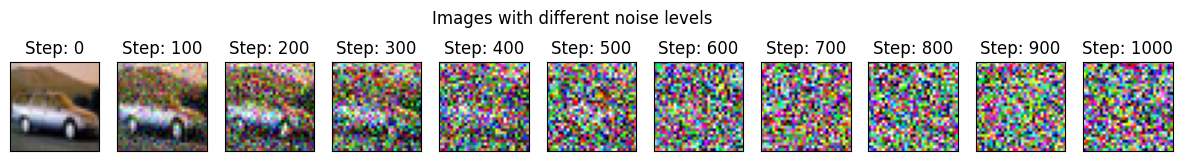

In [15]:
class Schedule():
    def __init__(self, beta1, beta2, T, device="cpu"):
        super().__init__()
        self.device = device
        self.num_steps = T

        # TODO: create torch vectors containing values for all timesteps
        # Hint: use torch.arange(0, T + 1, dtype=torch.float32, device=device) / T to create the betas
        self.beta_t = torch.arange(0, T + 1, dtype=torch.float32, device=device) / T * (beta2 - beta1) + beta1
        self.sqrt_beta_t = torch.sqrt(self.beta_t)
        self.alpha_t = 1 - self.beta_t

        self.alphabar_t = torch.zeros(T + 1, device=device)
        self.alphabar_t[0] = self.alpha_t[0]

        for i in range(1, T + 1):
            self.alphabar_t[i] = self.alphabar_t[i - 1] * self.alpha_t[i]

        self.sqrtab = torch.sqrt(self.alphabar_t)
        self.oneover_sqrta = 1 / torch.sqrt(self.alpha_t)
        self.sqrtmab = torch.sqrt(1 - self.sqrtab)
        self.mab_over_sqrtmab_inv = self.beta_t / self.sqrtmab


# show images with different noise levels
schedule = Schedule(1e-4, 0.02, 1000)

# plot the schedule
vis = Visualizer(num_rows=2, num_cols=4, figsize=(15, 8), axis_off=False, title='Schedule')
vis.add_subplot(0, 0, schedule.sqrt_beta_t, title_str=r'$\sqrt{\beta_t}$')
vis.add_subplot(0, 1, schedule.alpha_t, title_str=r'$\alpha_t$')
vis.add_subplot(1, 0, schedule.alphabar_t, title_str=r'$\bar{\alpha}_t$')
vis.add_subplot(1, 1, schedule.sqrtab, title_str=r'$\sqrt{\bar{\alpha}_t}$')
vis.add_subplot(0, 2, schedule.oneover_sqrta, title_str=r'$\frac{1}{\sqrt{\alpha_t}}$')
vis.add_subplot(0, 3, schedule.sqrtmab, title_str=r'$\sqrt{1 - \bar{\alpha}_t}$')
vis.add_subplot(1, 2, schedule.mab_over_sqrtmab_inv, title_str=r'$\frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}}$')

vis = Visualizer(num_rows=1, num_cols=11, figsize=(15, 2), axis_off=True, title='Images with different noise levels')
for i in range(11):
    img, _ = cifar_train_reduced[0]
    noise = torch.randn(img.shape)
    step = i * (schedule.num_steps // 10)

    # TODO: compute noised sample
    img = img * schedule.sqrtab[step] + noise * schedule.sqrtmab[step]

    # normalise for display
    img = (img + 1) / 2
    img = img.clip(0, 1)
    img = img.permute(1, 2, 0)
    vis.add_image_subplot(0, i, img.numpy(), title_str=f'Step: {step}')

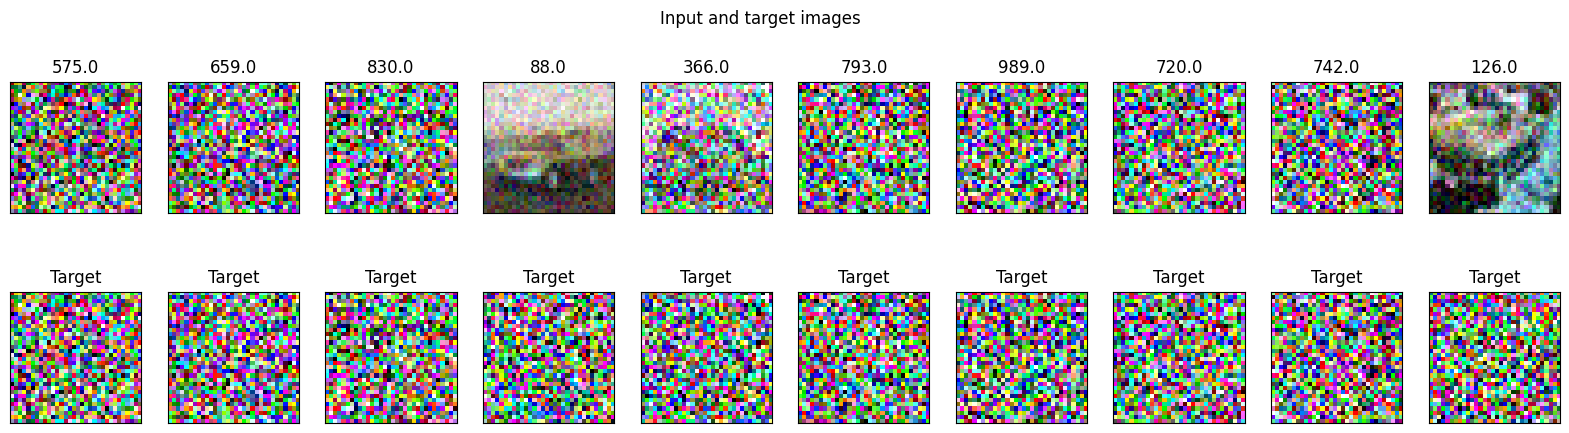

In [16]:
def generate_input_target(batch, schedule):
    timesteps = torch.randint(schedule.num_steps + 1, (batch.shape[0], 1), device=schedule.device)
    noise = torch.randn(batch.shape, device=schedule.device)
    # TODO
    for i in range(batch.shape[0]):
        batch[i] = batch[i] * schedule.sqrtab[timesteps[i][0]] + noise[i] * schedule.sqrtmab[timesteps[i][0]]

    return batch, noise, timesteps.float()

# visualise 4 input and target images
vis = Visualizer(num_rows=2, num_cols=10, figsize=(20, 5), axis_off=True, title='Input and target images')
batch, _ = next(iter(train_loader))

input_imgs, targets, timesteps = generate_input_target(batch, schedule)

input_imgs = (input_imgs*0.5+0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)
targets = (targets*0.5+0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)

for i in range(10):
    vis.add_image_subplot(0, i, input_imgs[i], title_str=f'{timesteps[i,0]}')
    vis.add_image_subplot(1, i, targets[i], title_str=f'Target')


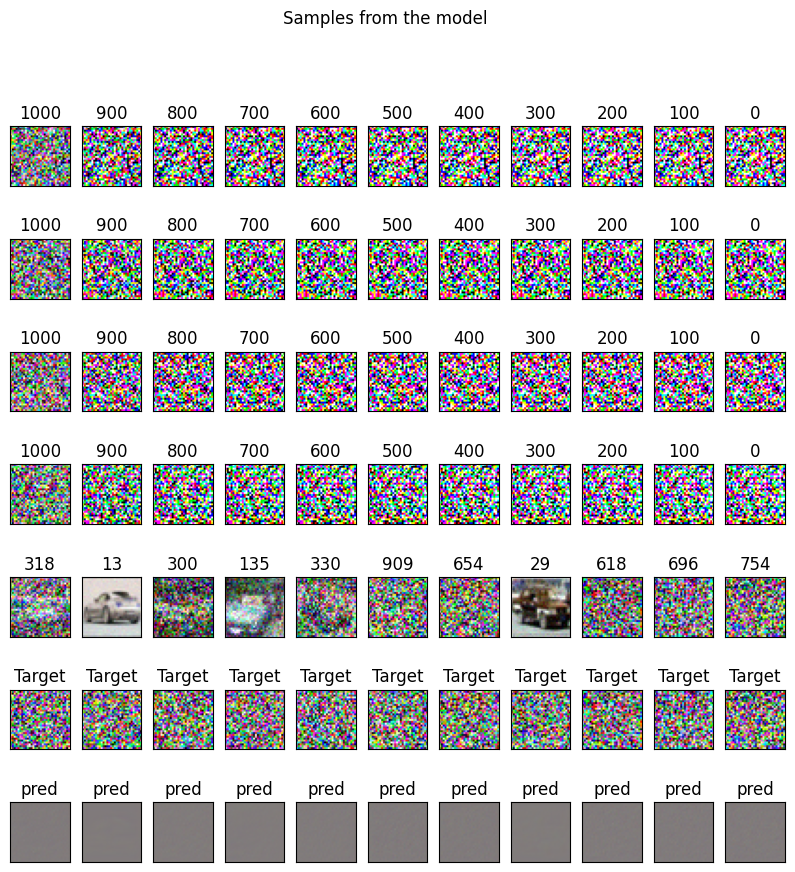

In [17]:
def sample(model, schedule):
    model.eval()
    sample = torch.randn(4, 3, 32, 32, device=schedule.device)

    vis = Visualizer(num_rows=sample.shape[0]+3, num_cols=11, figsize=(10, 10), axis_off=True, title='Samples from the model')
    with torch.no_grad():
        for i in tqdm(range(schedule.num_steps, 0, -1)):
            # TODO: compute sample
            sample = schedule.oneover_sqrta[i] * (sample - schedule.mab_over_sqrtmab_inv[i] * model(sample, i))
            if i > 1:
                sample += schedule.sqrt_beta_t[i] * torch.randn(4, 3, 32, 32, device=schedule.device)

            # plotting
            if i % (schedule.num_steps // 10) == 0:
                img = (sample*0.5 + 0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)
                for j in range(sample.shape[0]):
                    vis.add_image_subplot(j, 10 - i//(schedule.num_steps // 10), img[j], title_str=f'{i}')

    # plot the final sample
    img = (sample*0.5 + 0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)
    for j in range(sample.shape[0]):
        vis.add_image_subplot(j, 10, img[j], title_str=f'{0}')

    # also show input-target-prediction triplets
    batch, _ = next(iter(train_loader))
    input_imgs, targets, timesteps = generate_input_target(batch.to(schedule.device), schedule)
    with torch.no_grad():
        pred = model(input_imgs, timesteps)

    input_imgs = (input_imgs*0.5+0.5).clip(0,1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    targets = (targets*0.5+0.5).clip(0,1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    pred = (pred*0.5+0.5).clip(0,1).cpu().detach().numpy().transpose(0, 2, 3, 1)
    for i in range(11):
        vis.add_image_subplot(sample.shape[0]+0, i, input_imgs[i], title_str=f'{int(timesteps[i,0])}')
        vis.add_image_subplot(sample.shape[0]+1, i, targets[i], title_str=f'Target')
        vis.add_image_subplot(sample.shape[0]+2, i, pred[i], title_str=f'pred')
    vis.show()

sample(Model(), Schedule(1e-4, 0.02, 1000))

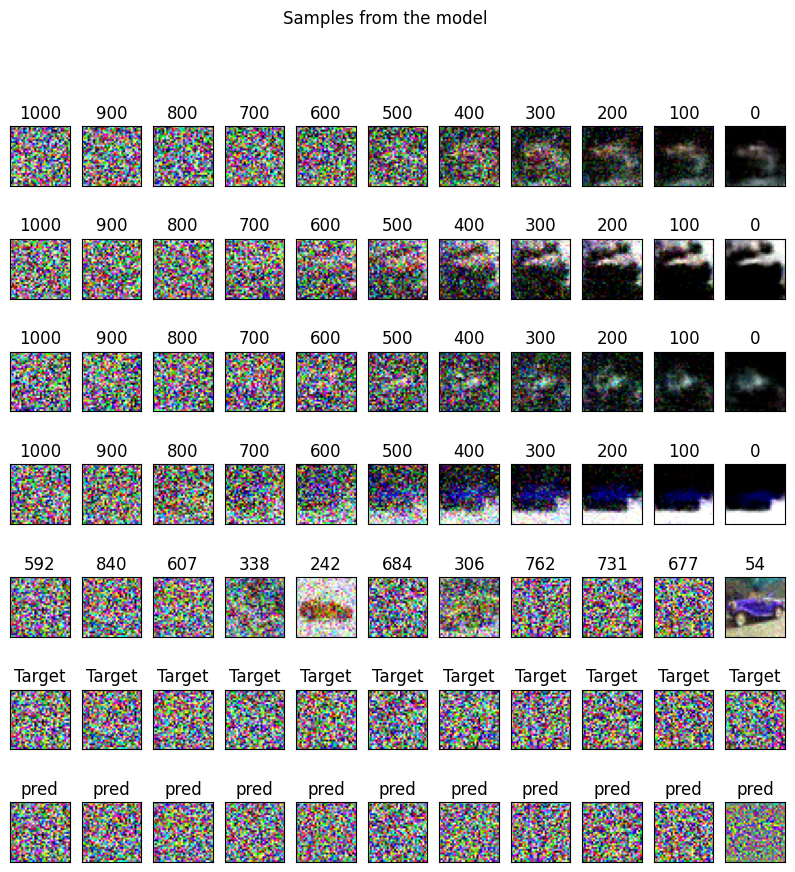

100%|██████████| 40/40 [00:03<00:00, 10.30it/s]


Epoch: 576 - Loss: 0.3018


100%|██████████| 40/40 [00:03<00:00, 12.86it/s]


Epoch: 577 - Loss: 0.2968


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


Epoch: 578 - Loss: 0.2976


100%|██████████| 40/40 [00:03<00:00, 12.06it/s]


Epoch: 579 - Loss: 0.3060


100%|██████████| 40/40 [00:03<00:00, 11.46it/s]


Epoch: 580 - Loss: 0.3037


100%|██████████| 40/40 [00:03<00:00, 12.76it/s]


Epoch: 581 - Loss: 0.3070


100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


Epoch: 582 - Loss: 0.2999


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch: 583 - Loss: 0.2995


100%|██████████| 40/40 [00:03<00:00, 12.04it/s]


Epoch: 584 - Loss: 0.3072


100%|██████████| 40/40 [00:03<00:00, 12.32it/s]


Epoch: 585 - Loss: 0.2966


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


Epoch: 586 - Loss: 0.3049


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch: 587 - Loss: 0.2971


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


Epoch: 588 - Loss: 0.3017


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


Epoch: 589 - Loss: 0.3042


100%|██████████| 40/40 [00:03<00:00, 12.85it/s]


Epoch: 590 - Loss: 0.3086


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch: 591 - Loss: 0.2959


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


Epoch: 592 - Loss: 0.2977


100%|██████████| 40/40 [00:03<00:00, 12.67it/s]


Epoch: 593 - Loss: 0.2978


 48%|████▊     | 19/40 [00:01<00:01, 12.12it/s]


KeyboardInterrupt: 

In [18]:
device="cuda:0"  # use "cpu" or "cuda:0"
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)  # this will slowly decrease the learning rate for stabilty
schedule = Schedule(1e-4, 0.02, 1000, device)

epoch_losses = []
for epoch in range(1000):
    losses = []
    model.train()
    for batch, _ in tqdm(train_loader):
        batch = batch.to(device)

        # TODO: compute targets, and loss
        input_imgs, targets, timesteps = generate_input_target(batch, schedule)
        preds = model(input_imgs, timesteps)
        loss = torch.norm(preds - targets, dim=1).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    lr_scheduler.step()
    model.eval()
    print(f'Epoch: {epoch} - Loss: {np.mean(losses):.4f}')
    if epoch % 25 == 0:
        sample(model, schedule)


print('Training finished')
sample(model, schedule)